Comparação de Modelos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random
random.seed(5)
from scipy import signal,stats
import os
import seaborn as sns

In [2]:
from datasets import DatasetSpgramSyntheticData
from models import SpectroViT
from losses import RangeMAELoss
from main_functions_adapted import run_validation
from metrics import calculate_shape_score, calculate_mse

Funções

In [3]:
def order_models(list_metric,model_names):
    values_order = np.sort(np.array(list_metric))
    idx_values_order = np.argsort(np.array(list_metric))
    models_ordered = []
    for idx in idx_values_order:
        models_ordered.append(model_names[idx]) 
    return models_ordered, values_order

In [4]:
def noise_est(ppm,x):
    noise = []
    for i in range(ppm.shape[0]):
        position_sup = np.abs(ppm[i,:]-12).argmin()
        position_inf = np.abs(ppm[i,:]-10).argmin()
        dt = np.polyfit(ppm[i,position_sup:position_inf], x[i,position_sup:position_inf], 2)
        sizeFreq = ppm[i,position_sup:position_inf].shape[0]
        stdev_Man = np.sqrt(np.sum(np.square(np.real(x[i,position_sup:position_inf] - np.polyval(dt, ppm[i,position_sup:position_inf])))) / (sizeFreq - 1))
        noise.append(stdev_Man)
    return np.mean(np.array(noise))

In [5]:
def get_max_gaba(ppm,x):
    max_gaba = [] 
    for i in range(ppm.shape[0]): 
        gaba_max_ind, gaba_min_ind = np.amax(np.where(ppm[i,:] >= 2.8)), np.amin(np.where(ppm[i,:] <= 3.2))
        max_aux = x[i,gaba_min_ind:gaba_max_ind].max()
        max_gaba.append(max_aux)
    return np.mean(np.array(max_gaba))

Definições

In [6]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [7]:
hop_size = [10,14,18,22,26,30,34]
window_size = 256
window = signal.windows.hann(256,sym = True)

In [8]:
spectrovit_10 = SpectroViT().to(device)
spectrovit_10.load_state_dict(torch.load('../model_hop_10_3500GT/models/model_hop_10_3500GT_best.pt',map_location= 'cpu'))
spectrovit_14 = SpectroViT().to(device)
spectrovit_14.load_state_dict(torch.load('../model_hop_14_3500GT/models/model_hop_14_3500GT_best.pt',map_location= 'cpu'))
spectrovit_18 = SpectroViT().to(device)
spectrovit_18.load_state_dict(torch.load('../model_hop_18_3500GT/models/model_hop_18_3500GT_best.pt',map_location= 'cpu'))
spectrovit_22 = SpectroViT().to(device)
spectrovit_22.load_state_dict(torch.load('../model_hop_22_3500GT/models/model_hop_22_3500GT_best.pt',map_location= 'cpu'))
spectrovit_26 = SpectroViT().to(device)
spectrovit_26.load_state_dict(torch.load('../model_hop_26_3500GT/models/model_hop_26_3500GT_best.pt',map_location= 'cpu'))
spectrovit_30 = SpectroViT().to(device)
spectrovit_30.load_state_dict(torch.load('../model_hop_30_3500GT/models/model_hop_30_3500GT_best.pt',map_location= 'cpu'))
spectrovit_34 = SpectroViT().to(device)
spectrovit_34.load_state_dict(torch.load('../model_hop_34_3500GT/models/model_hop_34_3500GT_best.pt',map_location= 'cpu'))

<All keys matched successfully>

In [9]:
list_models = [spectrovit_10.eval(), spectrovit_14.eval(), spectrovit_18.eval(), 
                spectrovit_22.eval(), spectrovit_26.eval(),spectrovit_30.eval(),
                spectrovit_34.eval()]
name_model = ['spectrovit_10','spectrovit_14',  'spectrovit_18', 
              'spectrovit_22', 'spectrovit_26','spectrovit_30',
              'spectrovit_34']
path_to_test_data = '../dataset_test_multiplenoise_from_SGT_4000_to_5000.h5'

Inferência: aquisição de métricas objetivas

In [10]:
dict_metrics = {}
for hop in hop_size:
    dataset_test = DatasetSpgramSyntheticData(path_data=path_to_test_data,
                        augment_with_noise=False,augment_with_idx_repetition=False,
                        hop_size=int(hop),window_size=window_size,window=window)
    dataloader_test = DataLoader(dataset_test, batch_size=10, shuffle=False)
    loss = RangeMAELoss()
    epoch = 0
    dict_metrics[str(int(hop))] = {'LossVal': [], 'MSEVal': [], 'SNRVal': [], 'FWHMVal': [], 'ShScVal': []}

    for model in list_models:
        val_loss, loader_mean_mse, loader_mean_snr,loader_mean_linewidth,loader_mean_shape_score,score_challenge = run_validation(model=model, criterion=loss, loader=dataloader_test, epoch=epoch, device=device)
        dict_metrics[str(int(hop))]['LossVal'].append(val_loss)
        dict_metrics[str(int(hop))]['MSEVal'].append(loader_mean_mse)
        dict_metrics[str(int(hop))]['SNRVal'].append(loader_mean_snr)
        dict_metrics[str(int(hop))]['FWHMVal'].append(loader_mean_linewidth)
        dict_metrics[str(int(hop))]['ShScVal'].append(loader_mean_shape_score)

Validation Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Generating Spectrograms of size:  (177, 199)
Zero padded to shape:  (1, 224, 224)


Validation Loop:   1%|          | 1/100 [00:00<00:20,  4.74it/s, desc=[Epoch 1] Loss: 0.004481748212128878 | MSE:0.0002232 | SNR:187.1718453 | FWHM:0.0764546 | Shape Score:0.9996997]

Generating Spectrograms of size:  (177, 142)
Zero padded to shape:  (1, 224, 224)


Validation Loop:   1%|          | 1/100 [00:00<00:19,  5.02it/s, desc=[Epoch 1] Loss: 0.0037773125804960728 | MSE:0.0002115 | SNR:278.4998889 | FWHM:0.0764546 | Shape Score:0.9997498]

Generating Spectrograms of size:  (177, 110)
Zero padded to shape:  (1, 224, 224)


Validation Loop:   1%|          | 1/100 [00:00<00:16,  6.10it/s, desc=[Epoch 1] Loss: 0.0028189048171043396 | MSE:0.0002121 | SNR:203.6897525 | FWHM:0.0764546 | Shape Score:0.9997479]

Generating Spectrograms of size:  (177, 90)
Zero padded to shape:  (1, 224, 224)


Validation Loop:   1%|          | 1/100 [00:00<00:15,  6.51it/s, desc=[Epoch 1] Loss: 0.0030321511439979076 | MSE:0.0002097 | SNR:240.3154959 | FWHM:0.0764546 | Shape Score:0.9997531]

Generating Spectrograms of size:  (177, 76)
Zero padded to shape:  (1, 224, 224)


Validation Loop:   1%|          | 1/100 [00:00<00:14,  6.99it/s, desc=[Epoch 1] Loss: 0.00281149847432971 | MSE:0.0002148 | SNR:213.4861929 | FWHM:0.0764546 | Shape Score:0.9997418]

Generating Spectrograms of size:  (177, 66)
Zero padded to shape:  (1, 224, 224)


Validation Loop:   1%|          | 1/100 [00:00<00:12,  7.65it/s, desc=[Epoch 1] Loss: 0.002965610008686781 | MSE:0.0002191 | SNR:208.1855440 | FWHM:0.0764546 | Shape Score:0.9997353]

Generating Spectrograms of size:  (177, 58)
Zero padded to shape:  (1, 224, 224)


Validation Loop: 100%|██████████| 100/100 [00:13<00:00,  7.46it/s, desc=[Epoch 1] Loss: 0.002755381865426898 | MSE:0.0003088 | SNR:474.4211981 | FWHM:0.0764546 | Shape Score:0.9997039]


Inferência: aquisição de objetos para visualização

In [11]:
predictions = {}
input_spgrams = {}
ppm_concat = np.empty((len(dataset_test),2048))
target_concat = np.empty((len(dataset_test),2048))

with torch.no_grad():
    for hop_idx,hop in enumerate(hop_size):
        dataset_test = DatasetSpgramSyntheticData(path_data=path_to_test_data,
                        augment_with_noise=False,augment_with_idx_repetition=False,
                        hop_size=int(hop),window_size=window_size,window=window)
        dataloader_test = DataLoader(dataset_test, batch_size=10, shuffle=False)
        predictions[str(int(hop))] = {}
        first_batch = True
        count = 0
        for data in dataloader_test:
            if first_batch == True:
                input_, target, ppm = data[0], data[1], data[2]
                input_ = input_.to(device)
                target = target.numpy()
                ppm = ppm.numpy()
                if hop_idx == 0:
                  ppm_concat[count*ppm.shape[0]:(count+1)*ppm.shape[0],:] = ppm
                  target_concat[count*target.shape[0]:(count+1)*target.shape[0],:] = target
                for i,model in enumerate(list_models):
                    prediction = model(input_).cpu().detach().numpy()
                    predictions[str(int(hop))][name_model[i]] = prediction
            
                input_spgram = input_.cpu().detach().numpy()
                input_spgrams[str(int(hop))] = input_spgram
                first_batch = False
                count=count+1
            else:
                input_, target, ppm = data[0], data[1], data[2]
                input_ = input_.to(device)
                target = target.numpy()
                ppm = ppm.numpy()
                if hop_idx == 0:
                  ppm_concat[count*ppm.shape[0]:(count+1)*ppm.shape[0],:] = ppm
                  target_concat[count*target.shape[0]:(count+1)*target.shape[0],:] = target
                for i,model in enumerate(list_models):
                    prediction = model(input_).cpu().detach().numpy()
                    predictions[str(int(hop))][name_model[i]] = np.concatenate((predictions[str(int(hop))][name_model[i]],prediction),axis=0)
            
                input_spgram = input_.cpu().detach().numpy()
                input_spgrams[str(int(hop))] = np.concatenate((input_spgrams[str(int(hop))],input_spgram),axis=0)
                count=count+1

Generating Spectrograms of size:  (177, 199)
Zero padded to shape:  (1, 224, 224)


Generating Spectrograms of size:  (177, 142)
Zero padded to shape:  (1, 224, 224)
Generating Spectrograms of size:  (177, 110)
Zero padded to shape:  (1, 224, 224)
Generating Spectrograms of size:  (177, 90)
Zero padded to shape:  (1, 224, 224)
Generating Spectrograms of size:  (177, 76)
Zero padded to shape:  (1, 224, 224)
Generating Spectrograms of size:  (177, 66)
Zero padded to shape:  (1, 224, 224)
Generating Spectrograms of size:  (177, 58)
Zero padded to shape:  (1, 224, 224)


Análise:

(0.0, 1.0, 0.0, 1.0)

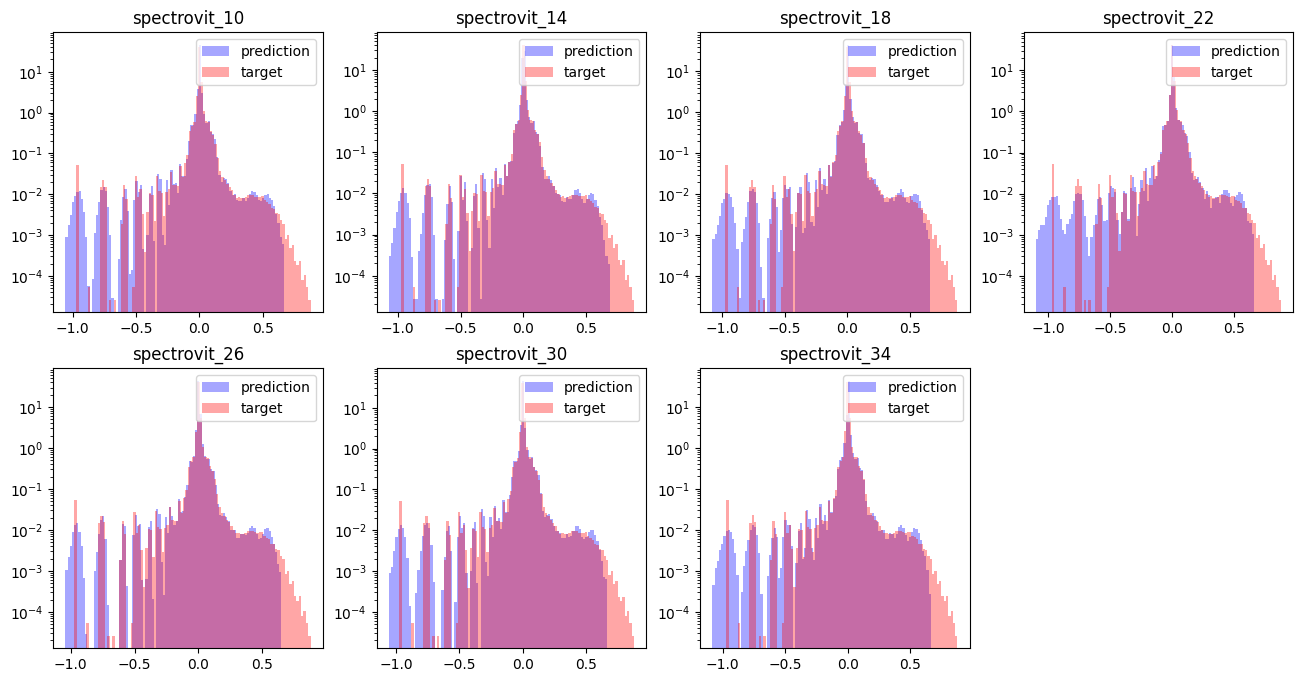

In [12]:
fig,ax = plt.subplots(2,4,figsize=(16,8))
for i,hop in enumerate(hop_size):
    ax.flat[i].hist(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten(),bins=100,density=True,alpha=0.35,color='b',label='prediction')
    ax.flat[i].hist(target_concat.flatten(),bins=100,density=True,alpha=0.35,color='r',label='target')
    ax.flat[i].set_yscale('log')
    ax.flat[i].set_title('spectrovit_'+str(int(hop)))
    ax.flat[i].legend(loc='upper right')
ax.flat[-1].axis('off')

In [13]:
print('range target:',np.min(target_concat),np.max(target_concat))
for i,hop in enumerate(hop_size):
    print('range predictions spectrovit_'+str(int(hop))+':',np.min(predictions[str(int(hop))]['spectrovit_'+str(int(hop))]),np.max(predictions[str(int(hop))]['spectrovit_'+str(int(hop))]))

range target: -0.9721150994300842 0.8788468241691589
range predictions spectrovit_10: -1.0567429 0.6693147
range predictions spectrovit_14: -1.0697004 0.6865923
range predictions spectrovit_18: -1.0759805 0.659412
range predictions spectrovit_22: -1.100448 0.6587314
range predictions spectrovit_26: -1.0418988 0.6512965
range predictions spectrovit_30: -1.0550405 0.66773564
range predictions spectrovit_34: -1.0823157 0.66501874


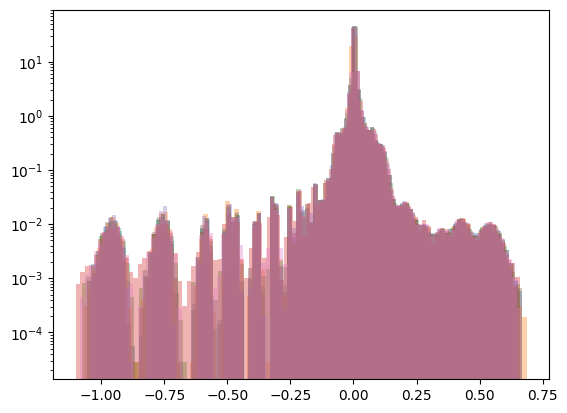

In [14]:
for i,hop in enumerate(hop_size):
    plt.hist(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten(),bins=100,density=True,alpha=0.35,label='spectrovit_'+str(int(hop)))
plt.yscale('log')

(0.0, 1.0, 0.0, 1.0)

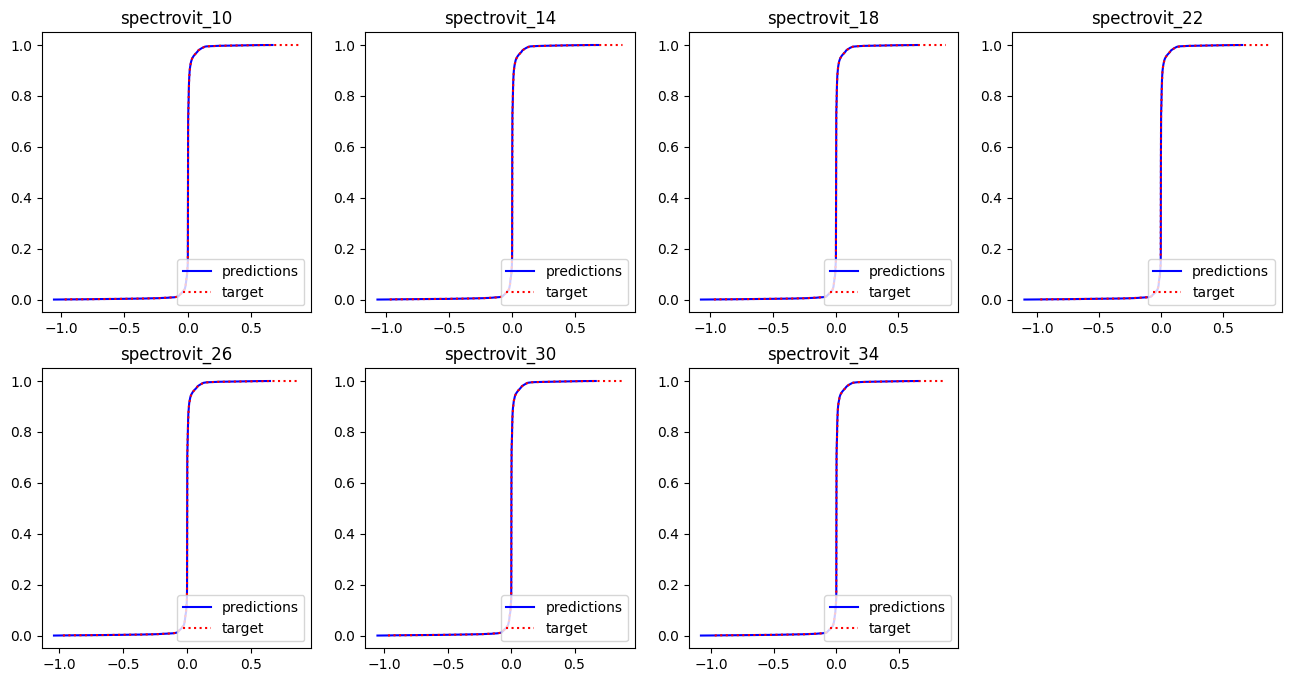

In [15]:
fig,ax = plt.subplots(2,4,figsize=(16,8))
for i,hop in enumerate(hop_size):
  data_sorted_pred = np.sort(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten())
  data_sorted_tgt = np.sort(target_concat.flatten())
  cumulative_pred = np.arange(1, len(data_sorted_pred) + 1) / len(data_sorted_pred)
  cumulative_tgt = np.arange(1, len(data_sorted_tgt) + 1) / len(data_sorted_tgt)
  ax.flat[i].plot(data_sorted_pred, cumulative_pred, linestyle='solid',color='b',label='predictions')
  ax.flat[i].plot(data_sorted_tgt, cumulative_tgt, linestyle='dotted',color='r',label='target')
  ax.flat[i].set_title('spectrovit_'+str(int(hop)))
  ax.flat[i].legend(loc='lower right')
ax.flat[-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

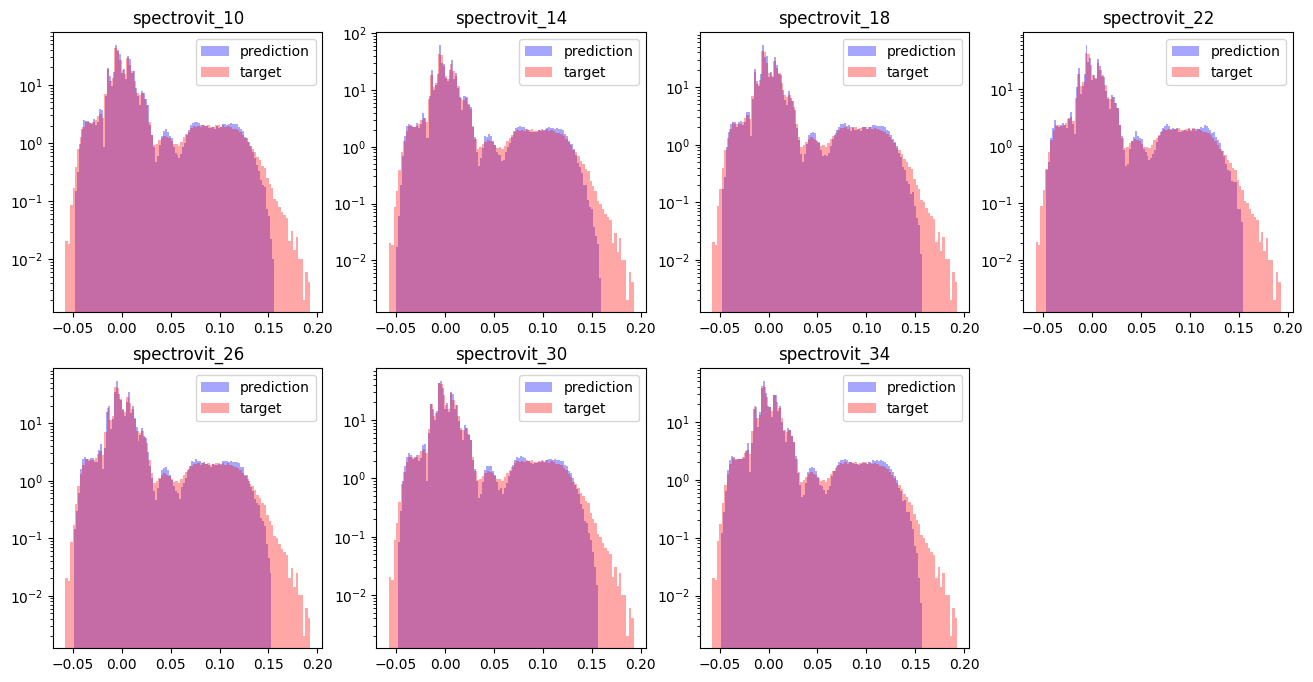

In [16]:
position_sup = np.abs(ppm_concat[0,:]-4).argmin()
position_inf = np.abs(ppm_concat[0,:]-2.5).argmin()
fig,ax = plt.subplots(2,4,figsize=(16,8))
for i,hop in enumerate(hop_size):
    ax.flat[i].hist(predictions[str(int(hop))]['spectrovit_'+str(int(hop))][:,position_sup:position_inf].flatten(),bins=100,density=True,alpha=0.35,color='b',label='prediction')
    ax.flat[i].hist(target_concat[:,position_sup:position_inf].flatten(),bins=100,density=True,alpha=0.35,color='r',label='target')
    ax.flat[i].set_yscale('log')
    ax.flat[i].set_title('spectrovit_'+str(int(hop)))
    ax.flat[i].legend(loc='upper right')
ax.flat[-1].axis('off')

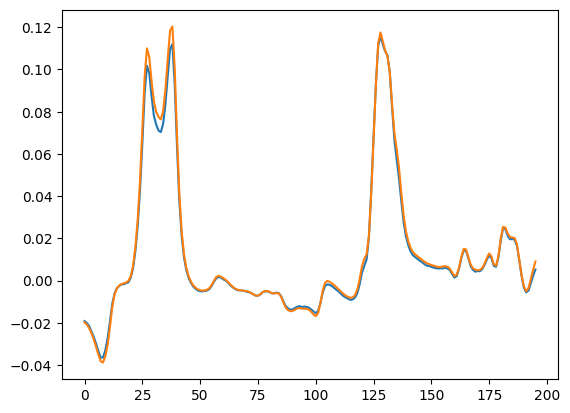

In [17]:
plt.plot(predictions[str(int(hop))]['spectrovit_'+str(int(hop))][0,position_sup:position_inf])
plt.plot(target_concat[0,position_sup:position_inf])

In [18]:
pred_stats = {'mean':[],'std':[],'median':[],'skew':[],'kurtosis':[]}
tgt_stats = {}
tgt_stats['mean']= np.mean(target_concat.flatten())
tgt_stats['std']= np.std(target_concat.flatten())
tgt_stats['median']= np.median(target_concat.flatten())
tgt_stats['skew']= stats.skew(target_concat.flatten())
tgt_stats['kurtosis']= stats.kurtosis(target_concat.flatten())
for i,hop in enumerate(hop_size):
  pred_stats['mean'].append(np.mean(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten()))
  pred_stats['std'].append(np.std(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten()))
  pred_stats['median'].append(np.median(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten()))
  pred_stats['skew'].append(stats.skew(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten()))
  pred_stats['kurtosis'].append(stats.kurtosis(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten()))
print('|..............Mean.......|...........STD..........|..........Median........|..............Skew.......|..........Kurtosis......|')
str_aux = ''
for i,key in enumerate(list(tgt_stats.keys())):
  if i == 0:
    str_aux=str_aux+'| '+ 'target        ' + '{:.4E}'.format(tgt_stats[key])+ '|'
  else:
    str_aux=str_aux+ 'target        ' + '{:.4E}'.format(tgt_stats[key])+ '|'
print(str_aux)
for j,hop in enumerate(hop_size):
  str_aux = ''
  for i,key in enumerate(list(tgt_stats.keys())):
    if i == 0:
      str_aux=str_aux+'| '+'spectrovit_'+str(int(hop))+' '+ '{:.4E}'.format(pred_stats[key][j])+ '|'
    else:
      str_aux=str_aux+'spectrovit_'+str(int(hop))+' '+ '{:.4E}'.format(pred_stats[key][j])+ '|'
  print(str_aux)

|..............Mean.......|...........STD..........|..........Median........|..............Skew.......|..........Kurtosis......|
| target        2.6875E-03|target        5.7722E-02|target        1.8956E-03|target        -6.6238E+00|target        1.3072E+02|
| spectrovit_10 2.6626E-03|spectrovit_10 5.7484E-02|spectrovit_10 1.8918E-03|spectrovit_10 -6.8201E+00|spectrovit_10 1.3170E+02|
| spectrovit_14 2.6010E-03|spectrovit_14 5.7298E-02|spectrovit_14 1.8379E-03|spectrovit_14 -6.8516E+00|spectrovit_14 1.3196E+02|
| spectrovit_18 2.6238E-03|spectrovit_18 5.7394E-02|spectrovit_18 1.8551E-03|spectrovit_18 -6.8365E+00|spectrovit_18 1.3215E+02|
| spectrovit_22 2.7044E-03|spectrovit_22 5.7782E-02|spectrovit_22 1.8979E-03|spectrovit_22 -6.8400E+00|spectrovit_22 1.3234E+02|
| spectrovit_26 2.6139E-03|spectrovit_26 5.7275E-02|spectrovit_26 1.8564E-03|spectrovit_26 -6.8514E+00|spectrovit_26 1.3191E+02|
| spectrovit_30 2.6569E-03|spectrovit_30 5.7533E-02|spectrovit_30 1.8810E-03|spectrovit_30 -6.825

In [94]:
metrics_names = ['LossVal','MSEVal','SNRVal','FWHMVal','ShScVal']
results_for_their_right_hop = {}
for metric in metrics_names:
        results_for_their_right_hop[metric] = [[],[]]
        aux = []
        for idx,model in enumerate(name_model):
                aux.append(dict_metrics[str(int(hop_size[idx]))][metric][idx])
        aux_model, aux_value = order_models(list_metric=aux,model_names=name_model)
        if metric == 'SNRVal' or metric == 'ShScVal':
                results_for_their_right_hop[metric][0] = aux_model[::-1]
                results_for_their_right_hop[metric][1] = np.flip(aux_value)
        else:
                results_for_their_right_hop[metric][0] = aux_model
                results_for_their_right_hop[metric][1] = aux_value
print('|..............LossVal.......|..............MSEVal........|..............SNRVal........|..............FWHMVal.......|..............ShScVal.......|')
for line_idx in range(len(name_model)):
        str_aux = ""
        for metric_idx,metric in enumerate(metrics_names):
                if metric_idx == 0:
                        str_aux = '| '+results_for_their_right_hop[metric][0][line_idx]+' | '+'{:.4E}'.format(results_for_their_right_hop[metric][1][line_idx])+' | ' 
                else:
                        str_aux = str_aux + results_for_their_right_hop[metric][0][line_idx]+' | '+'{:.4E}'.format(results_for_their_right_hop[metric][1][line_idx])+' | ' 
        print(str_aux)

|..............LossVal.......|..............MSEVal........|..............SNRVal........|..............FWHMVal.......|..............ShScVal.......|
| spectrovit_14 | 2.6331E-03 | spectrovit_30 | 3.0162E-04 | spectrovit_34 | 4.7442E+02 | spectrovit_10 | 7.6455E-02 | spectrovit_26 | 9.9971E-01 | 
| spectrovit_10 | 2.6693E-03 | spectrovit_34 | 3.0878E-04 | spectrovit_30 | 4.2986E+02 | spectrovit_14 | 7.6455E-02 | spectrovit_18 | 9.9970E-01 | 
| spectrovit_18 | 2.6705E-03 | spectrovit_18 | 3.1045E-04 | spectrovit_22 | 4.1720E+02 | spectrovit_18 | 7.6455E-02 | spectrovit_34 | 9.9970E-01 | 
| spectrovit_26 | 2.7104E-03 | spectrovit_26 | 3.1333E-04 | spectrovit_10 | 4.0735E+02 | spectrovit_22 | 7.6455E-02 | spectrovit_10 | 9.9970E-01 | 
| spectrovit_30 | 2.7419E-03 | spectrovit_10 | 3.1372E-04 | spectrovit_14 | 3.9241E+02 | spectrovit_26 | 7.6455E-02 | spectrovit_30 | 9.9970E-01 | 
| spectrovit_22 | 2.7471E-03 | spectrovit_14 | 3.1400E-04 | spectrovit_18 | 3.9023E+02 | spectrovit_30 | 7.6455E-

In [ ]:
score_model_for_their_right_hop = {}
for model in name_model:
    score_model_for_their_right_hop[model] = 0
for metric in metrics_names:
    if metric != 'LossVal':
        no_repeat = np.unique(results_for_their_right_hop[metric][1])
        max_point = len(no_repeat)
        for model_idx in range(len(results_for_their_right_hop[metric][0])):
            if model_idx == 0:
                add_to_score = max_point
            else:
                if results_for_their_right_hop[metric][1][model_idx] != results_for_their_right_hop[metric][1][model_idx-1]:
                    add_to_score = add_to_score-1
            score_model_for_their_right_hop[results_for_their_right_hop[metric][0][model_idx]] = score_model_for_their_right_hop[results_for_their_right_hop[metric][0][model_idx]] + add_to_score
aux = []
for model in name_model:
    aux.append(score_model_for_their_right_hop[model])
models_scored_for_their_right_hop, models_score_value_for_their_right_hop = order_models(list_metric=aux,model_names=name_model)
for i in reversed(range(len(models_scored_for_their_right_hop))):
    print(models_scored_for_their_right_hop[i] + ': '+str(models_score_value_for_their_right_hop[i]))

spectrovit_34: 19
spectrovit_30: 17
spectrovit_18: 14
spectrovit_26: 13
spectrovit_10: 12
spectrovit_22: 8
spectrovit_14: 8


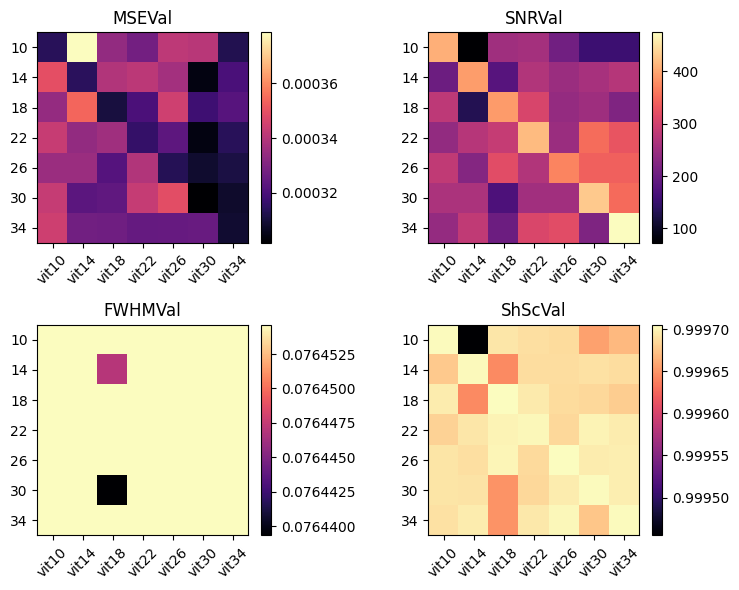

In [36]:
fig,ax=plt.subplots(2,2,figsize=(8,6))
for i,metric in enumerate(metrics_names[1:]):
    aux = []
    for hop in hop_size:
        aux.append(dict_metrics[str(int(hop))][metric])
    im=ax.flat[i].imshow(np.array(aux),cmap='magma')
    fig.colorbar(im, ax=ax.flat[i],fraction=0.046, pad=0.04)
    # Set custom ticks and labels
    ax.flat[i].set_xticks(ticks=np.arange(len(hop_size)), labels=['vit10','vit14','vit18','vit22','vit26','vit30','vit34'], rotation=45)
    ax.flat[i].set_yticks(ticks=np.arange(len(hop_size)), labels=['10','14','18','22','26','30','34'] )
    ax.flat[i].set_title(metric)
plt.tight_layout()

In [32]:
for hop in hop_size:
    print('noise estimation on prediction of'+' spectrovit_'+str(int(hop))+':',noise_est(ppm_concat,predictions[str(int(hop))]['spectrovit_'+str(int(hop))]),' GABA max:',get_max_gaba(ppm_concat,predictions[str(int(hop))]['spectrovit_'+str(int(hop))]))

noise estimation on prediction of spectrovit_10: 0.0001741015598388489  GABA max: 0.12823819
noise estimation on prediction of spectrovit_14: 0.00017918009507076845  GABA max: 0.12722233
noise estimation on prediction of spectrovit_18: 0.00017987767133367433  GABA max: 0.12761079
noise estimation on prediction of spectrovit_22: 0.00017419080827024328  GABA max: 0.12897672
noise estimation on prediction of spectrovit_26: 0.00018469241307238814  GABA max: 0.12738468
noise estimation on prediction of spectrovit_30: 0.000161112790607447  GABA max: 0.12828514
noise estimation on prediction of spectrovit_34: 0.00015601364651396092  GABA max: 0.12811302


In [44]:
results_for_each_hop = {}
for hop in hop_size:
    results_for_each_hop[str(int(hop))] = {}
    for metric in metrics_names:
        results_for_each_hop[str(int(hop))][metric] = [[],[]]
        aux_model,aux_value = order_models(list_metric=dict_metrics[str(int(hop))][metric],model_names=name_model)
        if metric == 'SNRVal' or metric == 'ShScVal':
            results_for_each_hop[str(int(hop))][metric][0] = aux_model[::-1]
            results_for_each_hop[str(int(hop))][metric][1] = np.flip(aux_value)
        else:
            results_for_each_hop[str(int(hop))][metric][0] = aux_model
            results_for_each_hop[str(int(hop))][metric][1] = aux_value

In [45]:
score_model_combined_hops = {}
for name in name_model:
    score_model_combined_hops[name] = [0,0,0,0,0]
for metric_idx, metric in enumerate(metrics_names):
    for hop in hop_size:
        no_repeat = np.unique(results_for_each_hop[str(int(hop))][metric][1])
        max_point = len(no_repeat)
        for model_idx in range(len(results_for_each_hop[str(int(hop))][metric][0])):
            model_ref = results_for_each_hop[str(int(hop))][metric][0][model_idx]
            if model_idx == 0:
                add_to_score = max_point
            else:
                if results_for_each_hop[str(int(hop))][metric][1][model_idx] != results_for_each_hop[str(int(hop))][metric][1][model_idx-1]: 
                    add_to_score = add_to_score-1                     
            score_model_combined_hops[model_ref][metric_idx] = score_model_combined_hops[model_ref][metric_idx] + add_to_score

to_print_results = {}
for metric_idx, metric in enumerate(metrics_names):
    aux = []
    for model in name_model:
        aux.append(score_model_combined_hops[model][metric_idx])
    aux_model, aux_value = order_models(list_metric=aux,model_names=name_model)
    to_print_results[metric] = [aux_model[::-1],np.flip(aux_value)]
print('|.......LossVal.......|.......MSEVal........|.......SNRVal........|.......FWHMVal.....|.......ShScVal.......|')
for line_idx in range(len(name_model)):
    str_aux = ""
    for metric_idx,metric in enumerate(metrics_names):
            if len(str(to_print_results[metric][1][line_idx])) == 2:
                space = '  | '
            else:
                space = ' | '
            if metric_idx == 0:
                str_aux = '| '+to_print_results[metric][0][line_idx]+' | '+str(to_print_results[metric][1][line_idx])+space 
            else:
                str_aux = str_aux + to_print_results[metric][0][line_idx]+' | '+str(to_print_results[metric][1][line_idx])+space
    print(str_aux)

|.......LossVal.......|.......MSEVal........|.......SNRVal........|.......FWHMVal.....|.......ShScVal.......|
| spectrovit_10 | 38  | spectrovit_34 | 41  | spectrovit_34 | 35  | spectrovit_18 | 9 | spectrovit_26 | 33  | 
| spectrovit_34 | 34  | spectrovit_30 | 41  | spectrovit_22 | 34  | spectrovit_34 | 7 | spectrovit_34 | 31  | 
| spectrovit_26 | 33  | spectrovit_22 | 27  | spectrovit_30 | 30  | spectrovit_30 | 7 | spectrovit_30 | 30  | 
| spectrovit_30 | 23  | spectrovit_18 | 27  | spectrovit_26 | 27  | spectrovit_26 | 7 | spectrovit_22 | 27  | 
| spectrovit_22 | 23  | spectrovit_26 | 23  | spectrovit_10 | 26  | spectrovit_22 | 7 | spectrovit_18 | 27  | 
| spectrovit_14 | 23  | spectrovit_14 | 20  | spectrovit_18 | 23  | spectrovit_14 | 7 | spectrovit_10 | 26  | 
| spectrovit_18 | 22  | spectrovit_10 | 17  | spectrovit_14 | 21  | spectrovit_10 | 7 | spectrovit_14 | 22  | 


In [46]:
total_score_models = []
for model in name_model:
    #exclude LossVal
    total_score_models.append(np.sum(np.array(score_model_combined_hops[model][1:])))
aux_model,aux_value = order_models(list_metric=total_score_models,model_names=name_model)
for i in reversed(range(len(aux_model))):
    print(aux_model[i]+': '+str(aux_value[i]))

spectrovit_34: 114
spectrovit_30: 108
spectrovit_22: 95
spectrovit_26: 90
spectrovit_18: 86
spectrovit_10: 76
spectrovit_14: 70


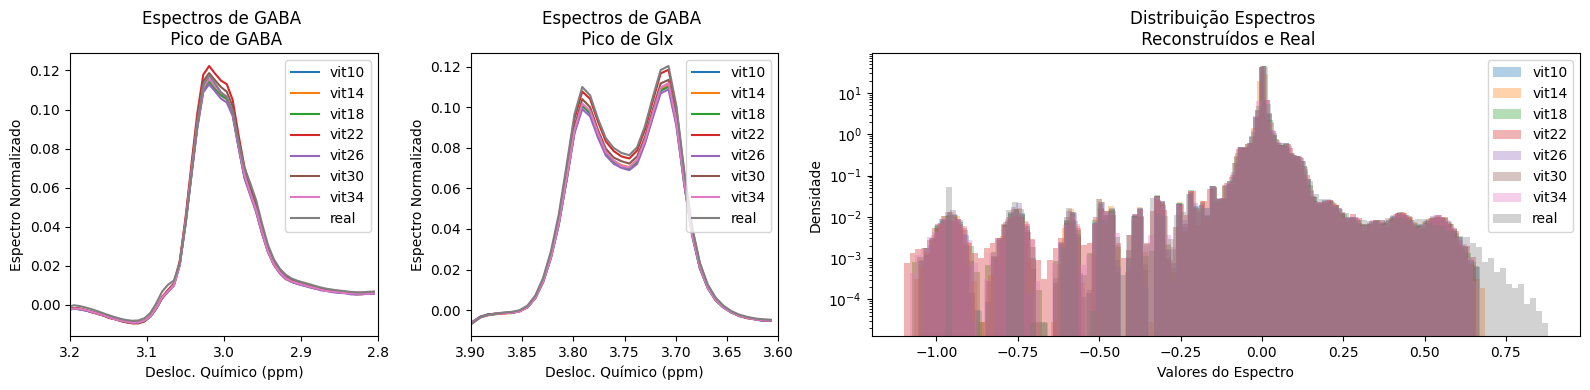

In [99]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0])  # First plot spans columns 0 and 1
ax2 = fig.add_subplot(gs[1])   # Second plot spans only the last column
ax3 = fig.add_subplot(gs[2:])   # Second plot spans only the last column
position_sup = np.abs(ppm_concat[0,:]-3.2).argmin()
position_inf = np.abs(ppm_concat[0,:]-2.8).argmin()
for i,hop in enumerate(hop_size):
    ax1.plot(ppm_concat[0,position_sup:position_inf], predictions[str(int(hop))][name_model[i]][0,position_sup:position_inf], label='vit'+str(int(hop)))
ax1.plot(ppm_concat[0,position_sup:position_inf],target_concat[0,position_sup:position_inf],label='real')
ax1.set_title('Espectros de GABA \n Pico de GABA')
ax1.set_xlabel('Desloc. Químico (ppm)')
ax1.set_ylabel('Espectro Normalizado')
ax1.set_xlim(3.2,2.8)
ax1.legend(loc='upper right')


position_sup = np.abs(ppm_concat[0,:]-3.9).argmin()
position_inf = np.abs(ppm_concat[0,:]-3.6).argmin()
for i,hop in enumerate(hop_size):
    ax2.plot(ppm_concat[0,position_sup:position_inf], predictions[str(int(hop))][name_model[i]][0,position_sup:position_inf], label='vit'+str(int(hop)))
ax2.plot(ppm_concat[0,position_sup:position_inf],target_concat[0,position_sup:position_inf],label='real')
ax2.set_title('Espectros de GABA \n Pico de Glx')
ax2.set_xlabel('Desloc. Químico (ppm)')
ax2.set_ylabel('Espectro Normalizado')
ax2.set_xlim(3.9,3.6)
ax2.legend(loc='upper right')


for i,hop in enumerate(hop_size):
    ax3.hist(predictions[str(int(hop))]['spectrovit_'+str(int(hop))].flatten(),bins=100,density=True,alpha=0.35,label='vit'+str(int(hop)))
ax3.hist(target_concat.flatten(),bins=100,density=True,alpha=0.35,label='real')
ax3.legend(loc='upper right')
ax3.set_title('Distribuição Espectros \n Reconstruídos e Real')
ax3.set_yscale('log')
ax3.set_xlabel('Valores do Espectro')
ax3.set_ylabel('Densidade')

plt.tight_layout()


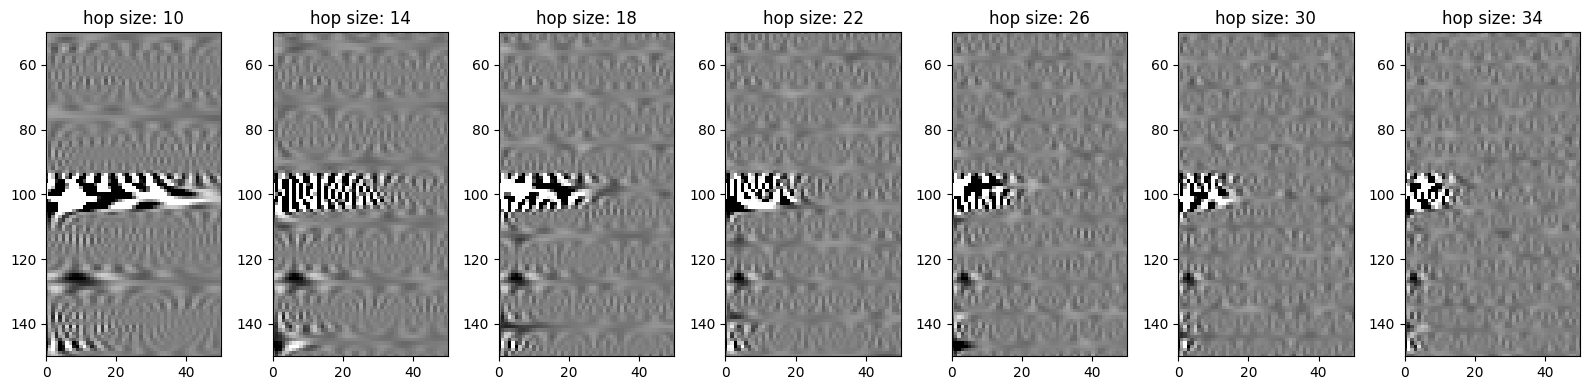

In [48]:
fig,ax = plt.subplots(1,7,figsize=(16,4))
for i,hop in enumerate(hop_size):
    ax.flat[i].imshow(input_spgrams[str(int(hop))][0,0,:,:],cmap='gray',vmin=-0.04,vmax=0.04,aspect='auto')
    ax.flat[i].set_title('hop size: '+str(int(hop)))
    ax.flat[i].set_ylim(150,50)
    ax.flat[i].set_xlim(0,50)
plt.tight_layout()
#plt.savefig('compare_models_synthdata_spgrams')


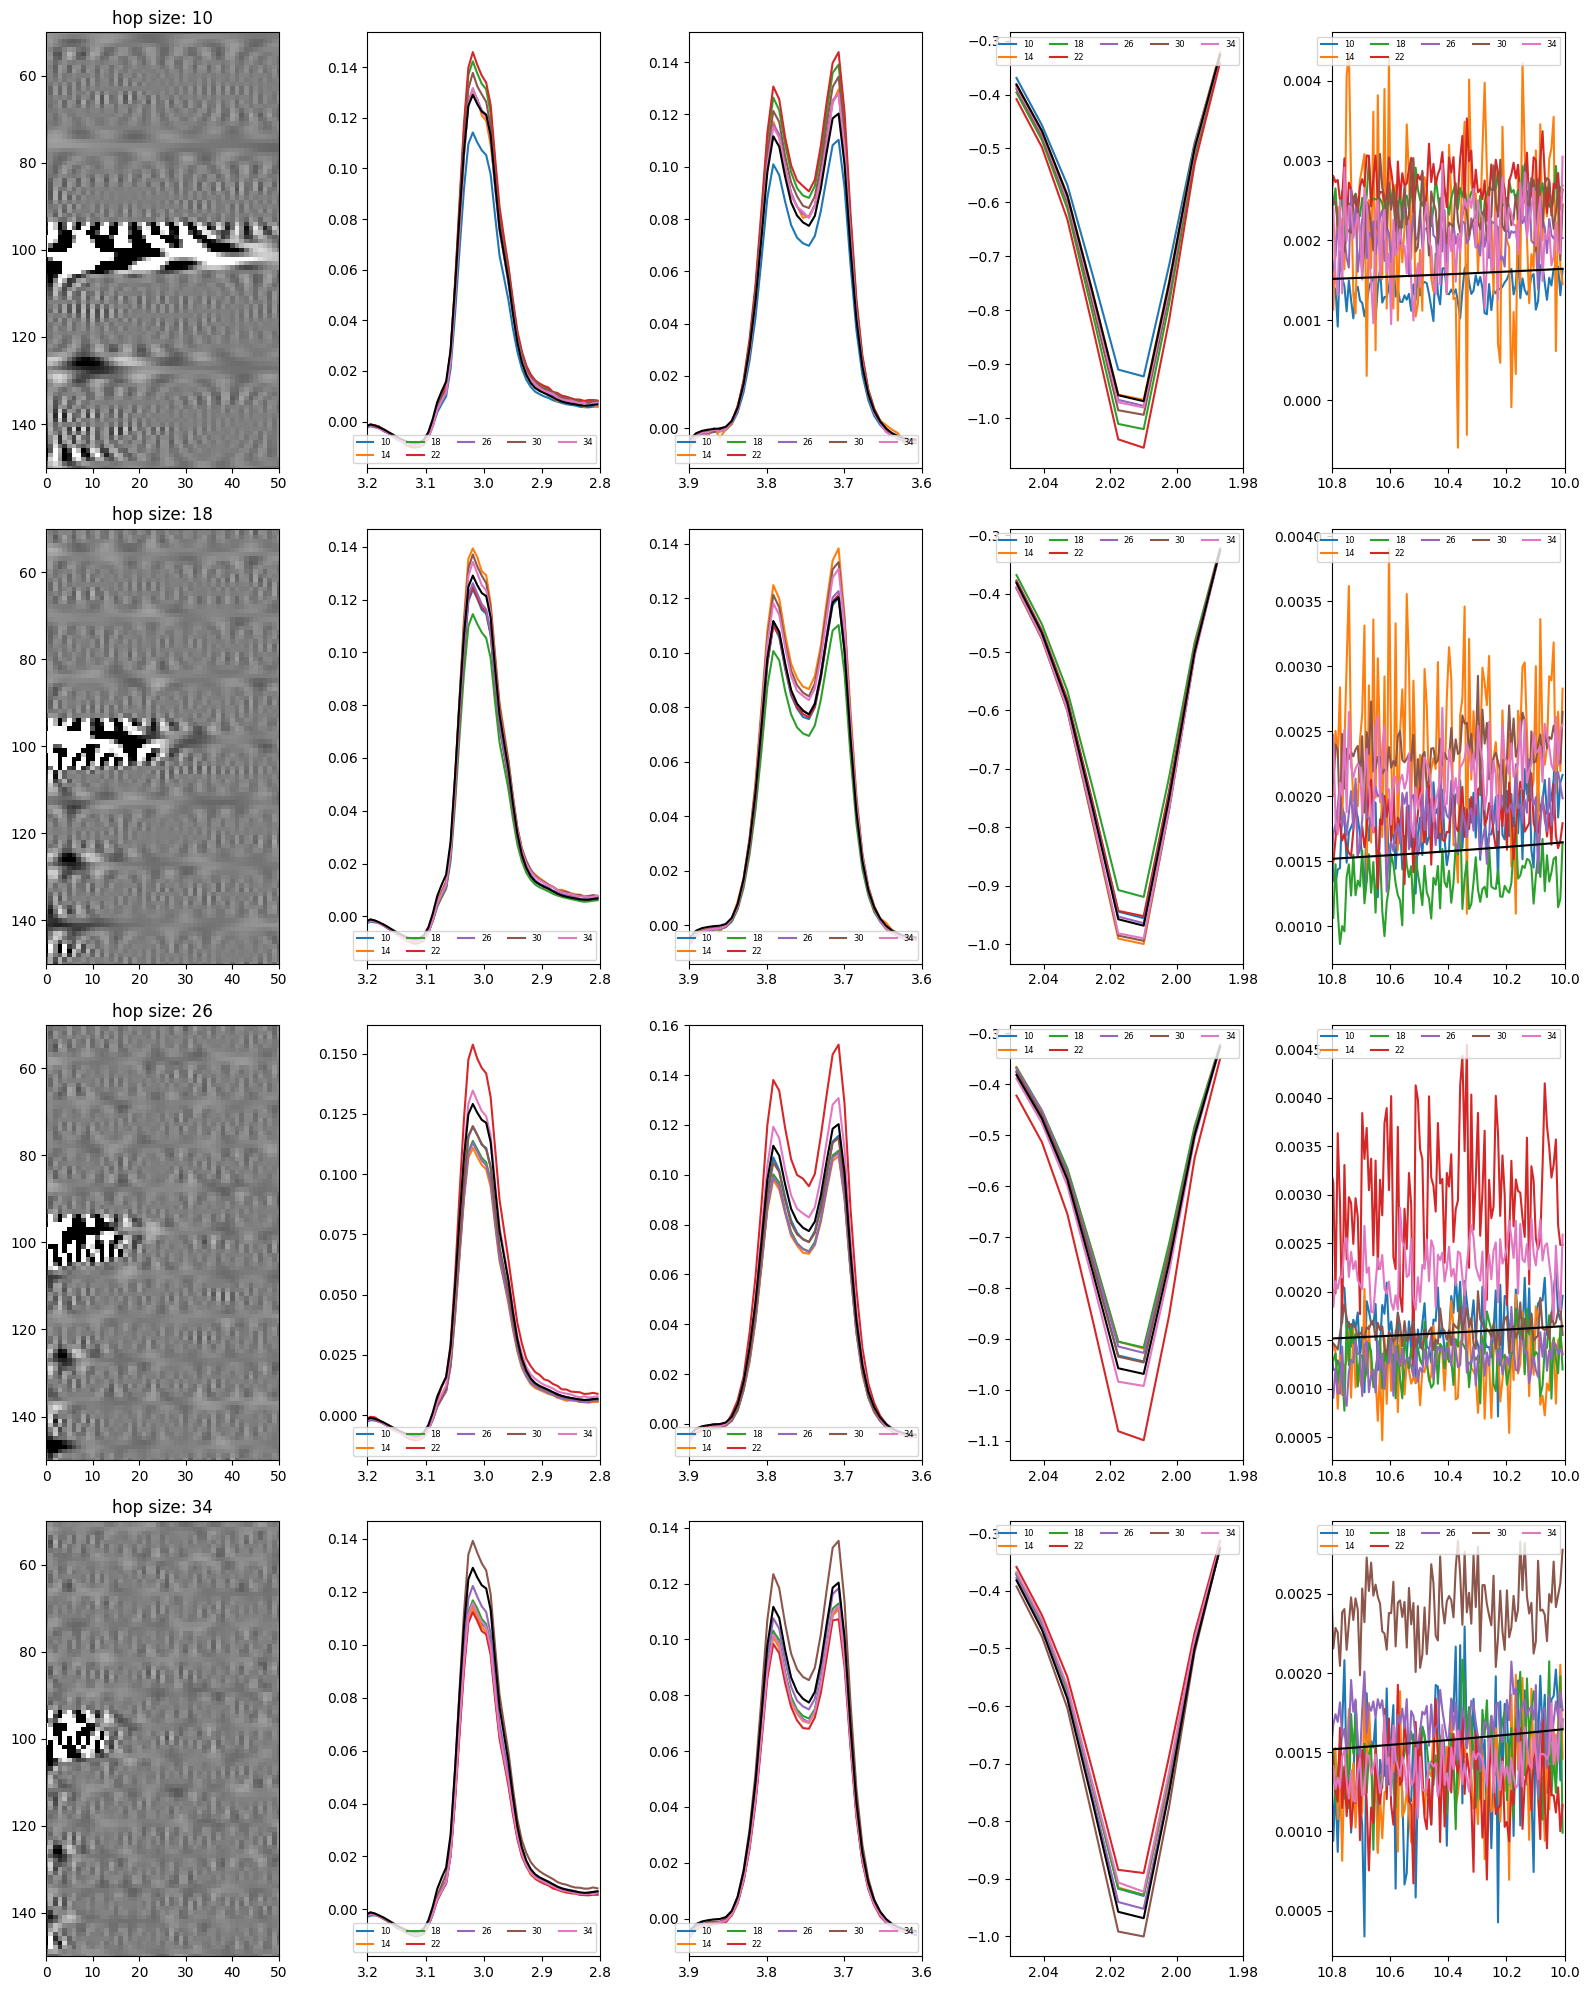

In [51]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
          'gold', 'darkviolet', 'lime', 'dodgerblue']
idx_to_plot=0
hop_idx_to_plot = [0,2,4,6]
fig,ax = plt.subplots(4,5,figsize=(16,20))
for k in range(len(hop_idx_to_plot)):
    ax.flat[5*k].imshow(input_spgrams[str(hop_size[hop_idx_to_plot[k]])][idx_to_plot,0,:,:],cmap='gray',vmin=-0.04,vmax=0.04,aspect='auto')
    ax.flat[5*k].set_title('hop size: '+str(hop_size[hop_idx_to_plot[k]]))
    ax.flat[5*k].set_ylim(150,50)
    ax.flat[5*k].set_xlim(0,50)
    regions = [[2.8,3.2],[3.6,3.9],[1.98,2.05],[10,10.8]]
    for j in range(4):
        position_sup = np.abs(ppm_concat[idx_to_plot,:]-regions[j][-1]).argmin()
        position_inf = np.abs(ppm_concat[idx_to_plot,:]-regions[j][0]).argmin()
        for i in range(len(name_model)):
            ax.flat[5*k+(j+1)].plot(ppm_concat[idx_to_plot,position_sup:position_inf], predictions[str(hop_size[hop_idx_to_plot[k]])][name_model[i]][idx_to_plot,position_sup:position_inf], label=name_model[i][-2:],color=colors[i])
        if j <2:
            ax.flat[5*k+(j+1)].legend(loc='lower right',fontsize=6,ncols=5)
        else:
            ax.flat[5*k+(j+1)].legend(loc='upper right',fontsize=6,ncols=5)
        ax.flat[5*k+(j+1)].plot(ppm_concat[idx_to_plot,position_sup:position_inf],target[idx_to_plot,position_sup:position_inf], color='black')
        ax.flat[5*k+(j+1)].set_xlim(regions[j][-1],regions[j][0])
plt.tight_layout()
#plt.savefig('compare_models_synthdata_reconstructionplots')

In [52]:
height_diff_per_hop = {'GABA':{},'Glx':{},'NAA':{}}
regions = [[2.8,3.2],[3.6,3.9],[1.98,2.05]]
for hop in hop_size:
    for j in range(3):
        height_diff_per_hop[list(height_diff_per_hop.keys())[j]][str(int(hop))] = []
        diff_height = {}
        for model in name_model:
            diff_height[model] = []
        for q in range(ppm_concat.shape[0]):
            position_sup = np.abs(ppm_concat[q,:]-regions[j][-1]).argmin()
            position_inf = np.abs(ppm_concat[q,:]-regions[j][0]).argmin()
            tgt_height = np.max(np.abs(target_concat[q,position_sup:position_inf]))
            for model in name_model:
                diff_height[model].append(np.max(np.abs(predictions[str(int(hop))][model][q,position_sup:position_inf]))-tgt_height)
        for model in name_model:
            aux = np.mean(np.array(diff_height[model]))
            height_diff_per_hop[list(height_diff_per_hop.keys())[j]][str(int(hop))].append(aux)

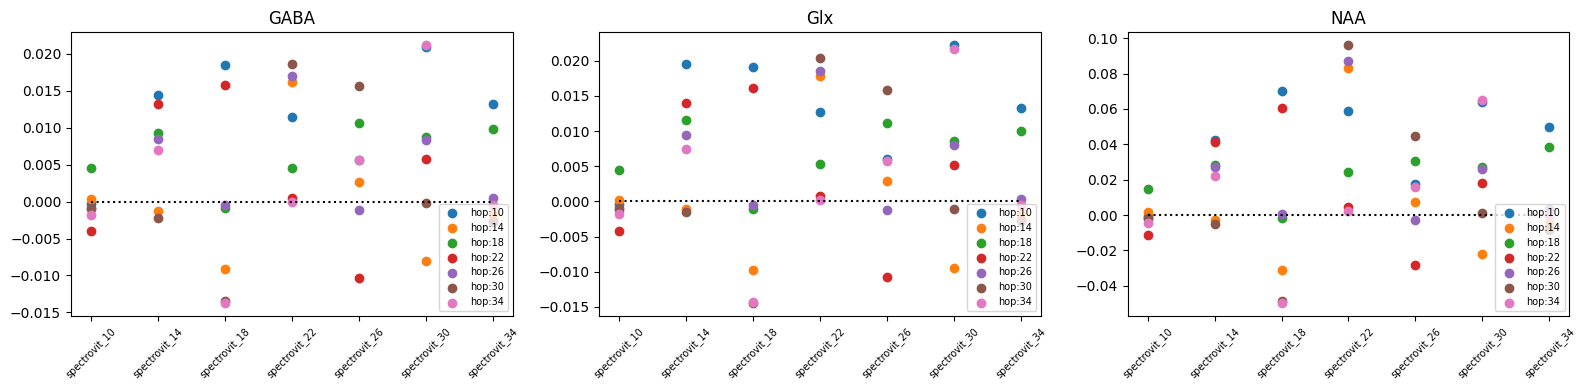

In [55]:
fig, ax = plt.subplots(1,3,figsize=(16,4),sharex='col')
for idx,key in enumerate(list(height_diff_per_hop.keys())):
    for hop in hop_size:
        ax.flat[idx].scatter(name_model,height_diff_per_hop[key][str(int(hop))],label='hop:'+str(int(hop)))
for i in range(3):
    ax.flat[i].plot(name_model,np.zeros(7),color='black',linestyle='dotted')
    ax.flat[i].set_xticks(ticks=name_model,labels=name_model,rotation=45,fontsize=7)
    ax.flat[i].legend(loc='lower right',fontsize=7)
ax.flat[0].set_title('GABA')
ax.flat[1].set_title('Glx')
ax.flat[2].set_title('NAA')
plt.tight_layout()

In [56]:
print('|..........GABA........|..............Glx.....|..............NAA.....|')
for line_idx in range(len(name_model)):
    str_aux = ""
    for idx,key in enumerate(list(height_diff_per_hop.keys())):
        counter_pos = 0
        counter_neg = 0
        for hop in hop_size:
            if height_diff_per_hop[key][str(int(hop))][line_idx] >= 0:
                counter_pos=counter_pos+1
            else:
                counter_neg=counter_neg+1
        if len(str(counter_neg))==1 and len(str(counter_pos))==1:
            space='   |'
        elif (len(str(counter_neg))==2 and len(str(counter_pos))==1) or (len(str(counter_neg))==1 and len(str(counter_pos))==2):
            space='  |'
        else:
            space=' |'
        if idx == 0:
            str_aux = str_aux + '|'+name_model[line_idx]+' | '+str(counter_pos)+'/'+str(counter_neg)+space
        else:
            str_aux = str_aux + name_model[line_idx]+' | '+str(counter_pos)+'/'+str(counter_neg)+space
    print(str_aux)

|..........GABA........|..............Glx.....|..............NAA.....|
|spectrovit_10 | 2/5   |spectrovit_10 | 2/5   |spectrovit_10 | 2/5   |
|spectrovit_14 | 5/2   |spectrovit_14 | 5/2   |spectrovit_14 | 5/2   |
|spectrovit_18 | 2/5   |spectrovit_18 | 2/5   |spectrovit_18 | 3/4   |
|spectrovit_22 | 6/1   |spectrovit_22 | 7/0   |spectrovit_22 | 7/0   |
|spectrovit_26 | 5/2   |spectrovit_26 | 5/2   |spectrovit_26 | 5/2   |
|spectrovit_30 | 5/2   |spectrovit_30 | 5/2   |spectrovit_30 | 6/1   |
|spectrovit_34 | 3/4   |spectrovit_34 | 3/4   |spectrovit_34 | 4/3   |


In [57]:
print('|..............GABA..........|..............Glx...........|..............NAA...........|')
for line_idx in range(len(name_model)):
    str_aux = ""
    for idx,key in enumerate(list(height_diff_per_hop.keys())):
        if height_diff_per_hop[key][str(int(hop_size[line_idx]))][line_idx] > 0: 
            space = '  |'
        else:
            space = ' |'
        if idx == 0:
            str_aux = str_aux + '|'+name_model[line_idx]+' | '+'{:.4E}'.format(height_diff_per_hop[key][str(int(hop_size[line_idx]))][line_idx])+space
        else:
            str_aux = str_aux + name_model[line_idx]+' | '+'{:.4E}'.format(height_diff_per_hop[key][str(int(hop_size[line_idx]))][line_idx])+space
    print(str_aux)

|..............GABA..........|..............Glx...........|..............NAA...........|
|spectrovit_10 | -2.9174E-04 |spectrovit_10 | -4.0093E-04 |spectrovit_10 | -7.1546E-04 |
|spectrovit_14 | -1.3076E-03 |spectrovit_14 | -1.0610E-03 |spectrovit_14 | -2.7522E-03 |
|spectrovit_18 | -9.1913E-04 |spectrovit_18 | -1.0026E-03 |spectrovit_18 | -1.5066E-03 |
|spectrovit_22 | 4.4678E-04  |spectrovit_22 | 8.4446E-04  |spectrovit_22 | 4.3495E-03  |
|spectrovit_26 | -1.1453E-03 |spectrovit_26 | -1.1717E-03 |spectrovit_26 | -2.5219E-03 |
|spectrovit_30 | -2.4479E-04 |spectrovit_30 | -1.0828E-03 |spectrovit_30 | 9.4339E-04  |
|spectrovit_34 | -4.1691E-04 |spectrovit_34 | -5.0048E-04 |spectrovit_34 | 3.0182E-05  |


In [58]:
proximity_shape_score = np.empty((len(hop_size),len(hop_size)))
proximity_MSE = np.empty((len(hop_size),len(hop_size)))
for model_idx,model in enumerate(name_model):
    aux_tgt = predictions[str(int(hop_size[model_idx]))][model]
    for model_idx_aux,model_aux in enumerate(name_model):
        if model_aux != model:
            aux = predictions[str(int(hop_size[model_idx]))][model_aux]
            aux_ss = []
            aux_mse = []
            for q in range(ppm_concat.shape[0]):
                aux_ss.append(calculate_shape_score(x=aux[q,:], y=aux_tgt[q,:],ppm=ppm_concat[q,:]))
                aux_mse.append(calculate_mse(x=aux[q,:], y=aux_tgt[q,:], ppm=ppm_concat[q,:]))
            proximity_shape_score[model_idx,model_idx_aux] = np.mean(np.array(aux_ss))
            proximity_MSE[model_idx,model_idx_aux] = np.mean(np.array(aux_mse))
        else:
            proximity_shape_score[model_idx,model_idx_aux] = 1
            proximity_MSE[model_idx,model_idx_aux] = 0

preds_flatten = {}
for j,name in enumerate(name_model):
    for i,hop in enumerate(hop_size):
        if i == 0:
            preds_flatten[name] = predictions[str(int(hop))][name].flatten()
        else:
            preds_flatten[name] = np.concatenate((preds_flatten[name],predictions[str(int(hop))][name].flatten()))

    if j == 0:
        data = preds_flatten[name]
    else:
        data = np.vstack([data,preds_flatten[name]])
correlation_matrix = np.corrcoef(data)

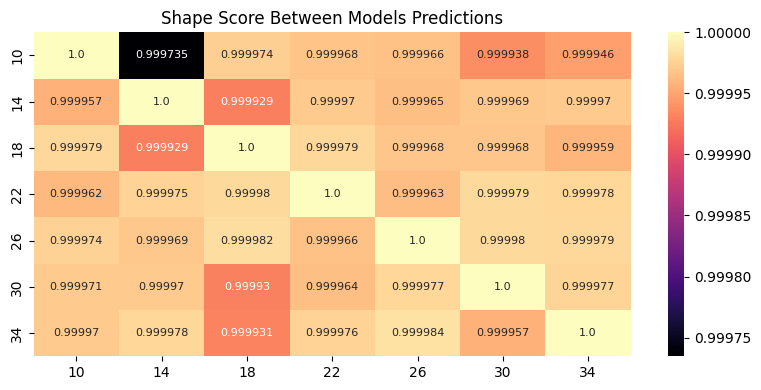

In [60]:
plt.figure(figsize=(8,4))
sns.heatmap(proximity_shape_score, annot=True, annot_kws={"size": 8}, fmt='.6', cmap='magma', xticklabels=['10', '14', '18', '22','26','30','34'], 
            yticklabels=['10', '14', '18', '22','26','30','34'])
plt.title('Shape Score Between Models Predictions')
plt.tight_layout()

In [61]:
for line_idx in range(proximity_shape_score.shape[0]):
    aux_model,aux_value = order_models(list_metric=proximity_shape_score[line_idx,:],model_names=name_model)
    print(name_model[line_idx]+': '+(aux_model[::-1])[1]+' | '+(aux_model[::-1])[2])

spectrovit_10: spectrovit_18 | spectrovit_22
spectrovit_14: spectrovit_34 | spectrovit_22
spectrovit_18: spectrovit_22 | spectrovit_10
spectrovit_22: spectrovit_18 | spectrovit_30
spectrovit_26: spectrovit_18 | spectrovit_30
spectrovit_30: spectrovit_26 | spectrovit_34
spectrovit_34: spectrovit_26 | spectrovit_14


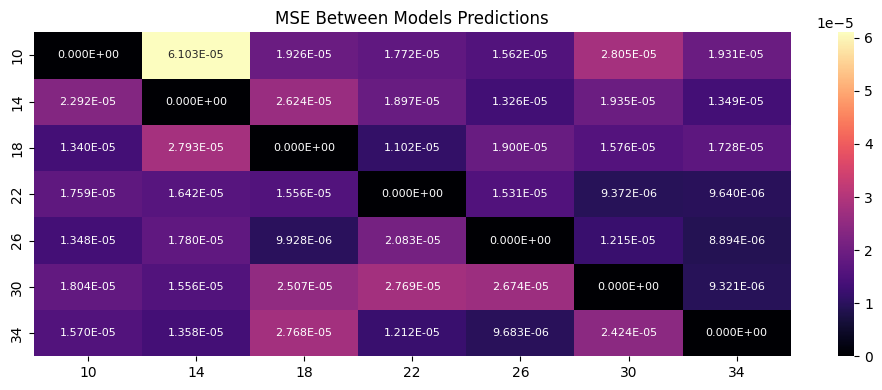

In [62]:
plt.figure(figsize=(10,4))
sns.heatmap(proximity_MSE, annot=True, annot_kws={"size": 8}, fmt='.3E', cmap='magma', xticklabels=['10', '14', '18', '22','26','30','34'], 
            yticklabels=['10', '14', '18', '22','26','30','34'])
plt.title('MSE Between Models Predictions')
plt.tight_layout()

In [63]:
for line_idx in range(proximity_MSE.shape[0]):
    aux_model,aux_value = order_models(list_metric=proximity_MSE[line_idx,:],model_names=name_model)
    print(name_model[line_idx]+': '+(aux_model)[1]+' | '+(aux_model)[2])

spectrovit_10: spectrovit_26 | spectrovit_22
spectrovit_14: spectrovit_26 | spectrovit_34
spectrovit_18: spectrovit_22 | spectrovit_10
spectrovit_22: spectrovit_30 | spectrovit_34
spectrovit_26: spectrovit_34 | spectrovit_18
spectrovit_30: spectrovit_34 | spectrovit_14
spectrovit_34: spectrovit_26 | spectrovit_22


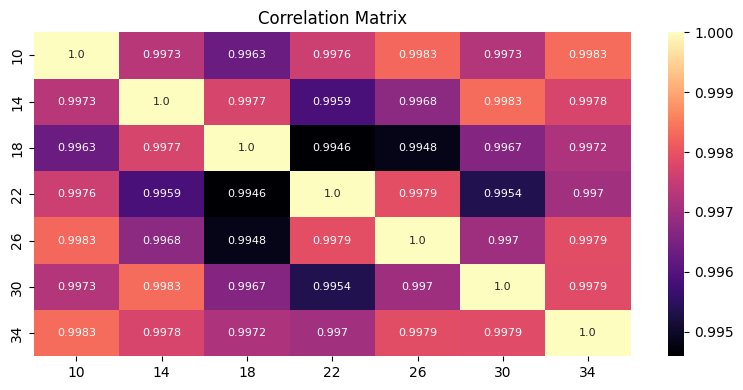

In [64]:
plt.figure(figsize=(8,4))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, fmt='.4', cmap='magma', xticklabels=['10', '14', '18', '22','26','30','34'], 
            yticklabels=['10', '14', '18', '22','26','30','34'])
plt.title('Correlation Matrix')
plt.tight_layout()

In [65]:
for line_idx in range(correlation_matrix.shape[0]):
    aux_model,aux_value = order_models(list_metric=correlation_matrix[line_idx,:],model_names=name_model)
    print(name_model[line_idx]+': '+(aux_model[::-1])[1]+' | '+(aux_model[::-1])[2])

spectrovit_10: spectrovit_34 | spectrovit_26
spectrovit_14: spectrovit_30 | spectrovit_34
spectrovit_18: spectrovit_14 | spectrovit_34
spectrovit_22: spectrovit_26 | spectrovit_10
spectrovit_26: spectrovit_10 | spectrovit_22
spectrovit_30: spectrovit_14 | spectrovit_34
spectrovit_34: spectrovit_10 | spectrovit_26


In [66]:
correlation_matrix_inputs = np.corrcoef(np.array([input_spgrams['10'].flatten(),
                                                  input_spgrams['14'].flatten(),
                                                  input_spgrams['18'].flatten(),
                                                  input_spgrams['22'].flatten(),
                                                  input_spgrams['26'].flatten(),
                                                  input_spgrams['30'].flatten(),
                                                  input_spgrams['34'].flatten()]))

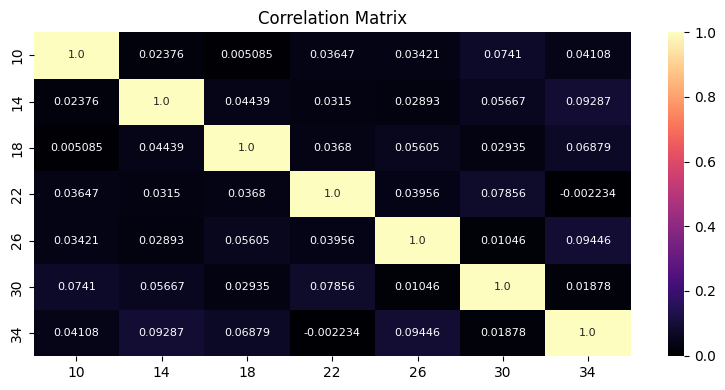

In [67]:
plt.figure(figsize=(8,4))
sns.heatmap(correlation_matrix_inputs, annot=True, annot_kws={"size": 8}, fmt='.4', cmap='magma', xticklabels=['10', '14', '18', '22','26','30','34'], 
            yticklabels=['10', '14', '18', '22','26','30','34'])
plt.title('Correlation Matrix')
plt.tight_layout()

In [68]:
for line_idx in range(correlation_matrix_inputs.shape[0]):
    aux_model,aux_value = order_models(list_metric=correlation_matrix_inputs[line_idx,:],model_names=name_model)
    print(name_model[line_idx]+': '+(aux_model[::-1])[1]+' | '+(aux_model[::-1])[2])

spectrovit_10: spectrovit_30 | spectrovit_34
spectrovit_14: spectrovit_34 | spectrovit_30
spectrovit_18: spectrovit_34 | spectrovit_26
spectrovit_22: spectrovit_30 | spectrovit_26
spectrovit_26: spectrovit_34 | spectrovit_18
spectrovit_30: spectrovit_22 | spectrovit_10
spectrovit_34: spectrovit_26 | spectrovit_14


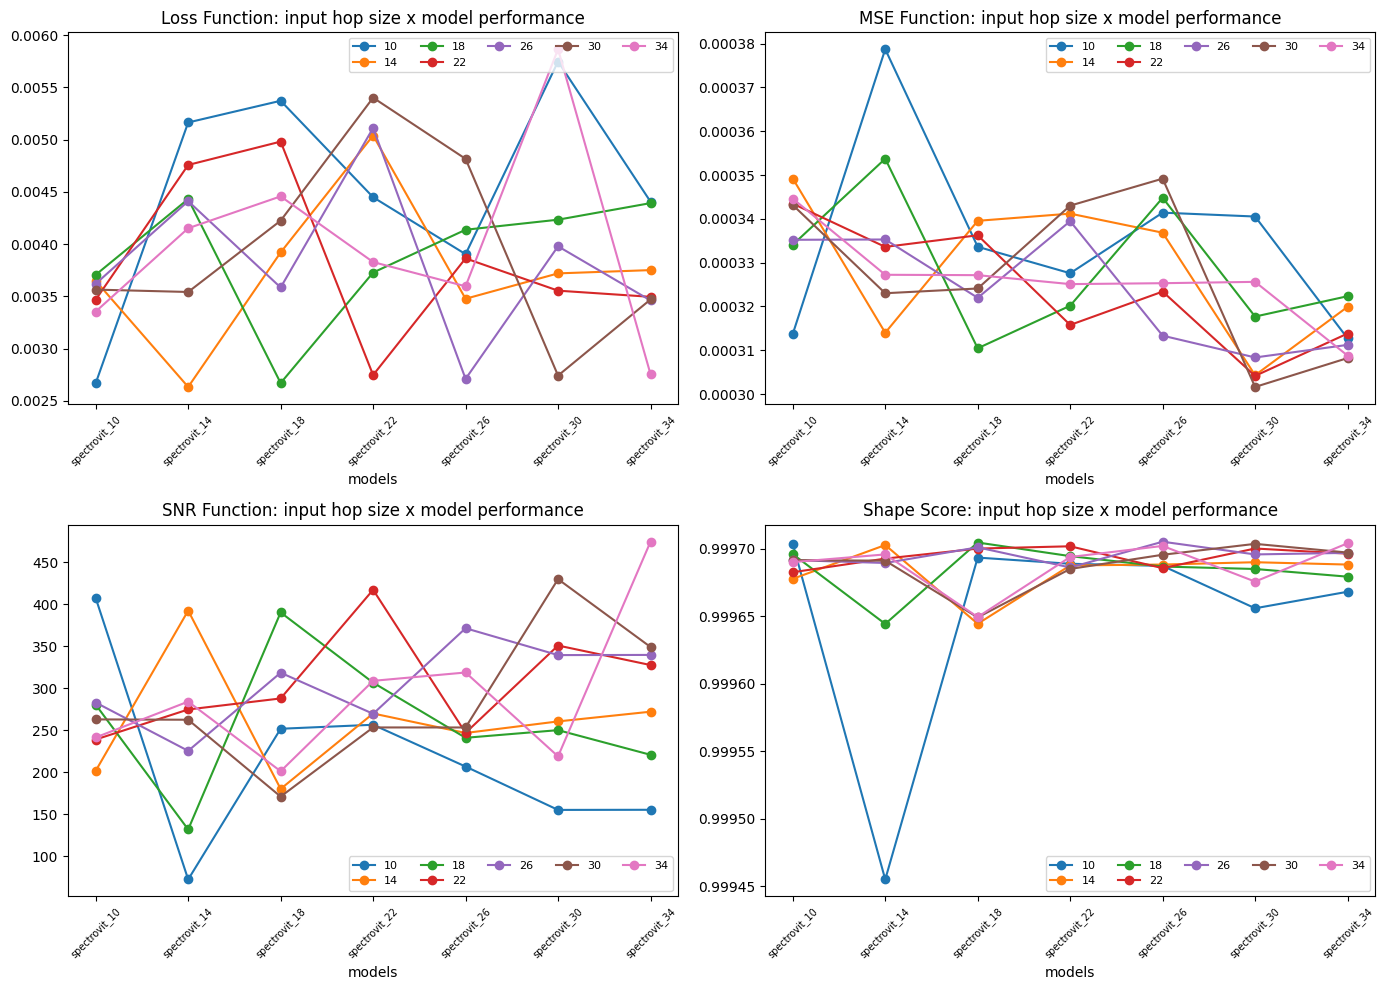

In [69]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
          'gold', 'darkviolet', 'lime', 'dodgerblue']
fig,ax = plt.subplots(2,2,figsize=(14,10))
for j,metric in enumerate(metrics_names):
    for i,hop in enumerate(hop_size):
        ax.flat[j].plot(name_model, dict_metrics[str(int(hop))][metric],marker='o',label=str(int(hop)), color=colors[i])
    if j<2:
        ax.flat[j].legend(loc='upper right',fontsize=8, ncols=5)
    else:
        ax.flat[j].legend(loc='lower right',fontsize=8, ncols=5)
    ax.flat[j].set_xticks(ticks=name_model,labels=name_model,rotation=45,fontsize=7)
    ax.flat[j].set_xlabel('models')
    if j == 0: 
        ax.flat[j].set_title('Loss Function: input hop size x model performance')
    elif j == 1: 
        ax.flat[j].set_title('MSE Function: input hop size x model performance')
    elif j == 2: 
        ax.flat[j].set_title('SNR Function: input hop size x model performance')
    else:
        ax.flat[j].set_title('Shape Score: input hop size x model performance')
plt.tight_layout()
#plt.savefig('compare_models_synthdata_inputhop_x_model')

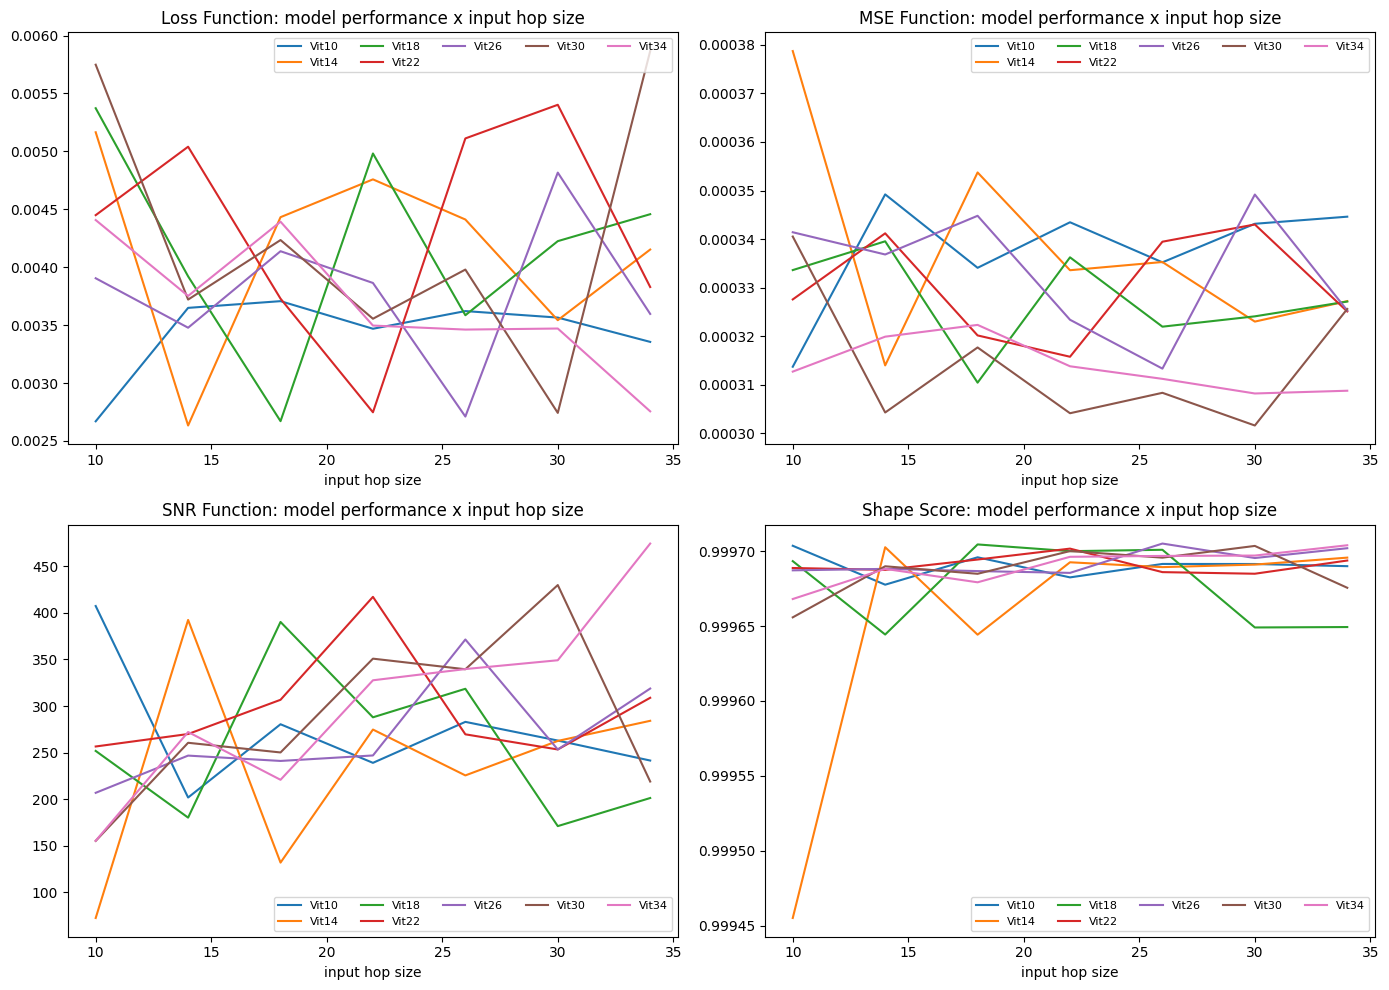

In [70]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
          'gold', 'darkviolet', 'lime', 'dodgerblue']
fig,ax = plt.subplots(2,2,figsize=(14,10))
for j,metric in enumerate(metrics_names):
    for i,model in enumerate(name_model):
        aux = []
        for hop in hop_size:
            aux.append(dict_metrics[str(int(hop))][metric][i])
        ax.flat[j].plot(hop_size,aux,label='Vit'+model[11:], color=colors[i])
    if j<2:
        ax.flat[j].legend(loc='upper right',fontsize=8, ncols=5)
    else:
        ax.flat[j].legend(loc='lower right',fontsize=8, ncols=5)
    ax.flat[j].set_xlabel('input hop size')
    if j == 0: 
        ax.flat[j].set_title('Loss Function: model performance x input hop size')
    elif j == 1: 
        ax.flat[j].set_title('MSE Function: model performance x input hop size')
    elif j == 2: 
        ax.flat[j].set_title('SNR Function: model performance x input hop size')
    else:
        ax.flat[j].set_title('Shape Score: model performance x input hop size')
plt.tight_layout()
#plt.savefig('compare_models_synthdata_model_x_inputhop')